# **Forecasting Data dengan Metode XGBoost**
XGBoost (*Extreme Gradient Boosting*) adalah sebuah algoritma *machine learning* yang efektif dalam analisis data, khususnya dalam tugas-tugas seperti klasifikasi, regresi, dan peringkatan berdasarkan teknik GBDT.

> Gradient Boosting Decision Trees (GBDT) adalah algoritma pembelajaran ansambel pohon keputusan yang mirip dengan algoritma *Random Forest*, untuk klasifikasi dan regresi.

![gbdt1.jpg](https://www.researchgate.net/profile/Sani-Abba-2/publication/358015005/figure/fig2/AS:1153280956739589@1651975015400/Gradient-boosting-decision-tree-GBDT.png)

GBDT secara iteratif melatih sebuah ensemble pohon keputusan dangkal, dengan setiap iterasi menggunakan residu kesalahan dari model sebelumnya agar sesuai dengan model berikutnya. Prediksi akhir adalah jumlah tertimbang dari semua prediksi pohon. Random forest meminimalkan *variance* dan *overfitting*, sementara GBDT “boosting” meminimalkan *bias* dan *underfitting*.




## 1. Membaca dan Menampilkan Dataframe
### Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Terdapat 4 kolom:
1. dates
2. number
3. temperature
4. humidity

dan 12.000 baris

In [ ]:
df = pd.read_csv('datasetSensor100.csv')
df = df.set_index('dates')
df.index = pd.to_datetime(df.index) # mengatur format kolom dates dari string menjadi datetime
df

,number,temperature,humidity
dates,,,
2023-09-02 07:44:22,1,24,79
2023-09-02 07:45:30,2,24,79
2023-09-02 07:46:48,3,24,79
2023-09-02 07:49:37,4,24,79
2023-09-02 07:51:04,5,24,79
...,...,...,...
2023-12-11 10:22:17,11996,27,81
2023-12-11 10:23:17,11997,27,81
2023-12-11 10:24:17,11998,27,81


## 2. Plot Kolom Dataframe (Temperatur dan Kelembapan)
Visualisasi kolom temperatur dan kelembapan dalam bentuk plot

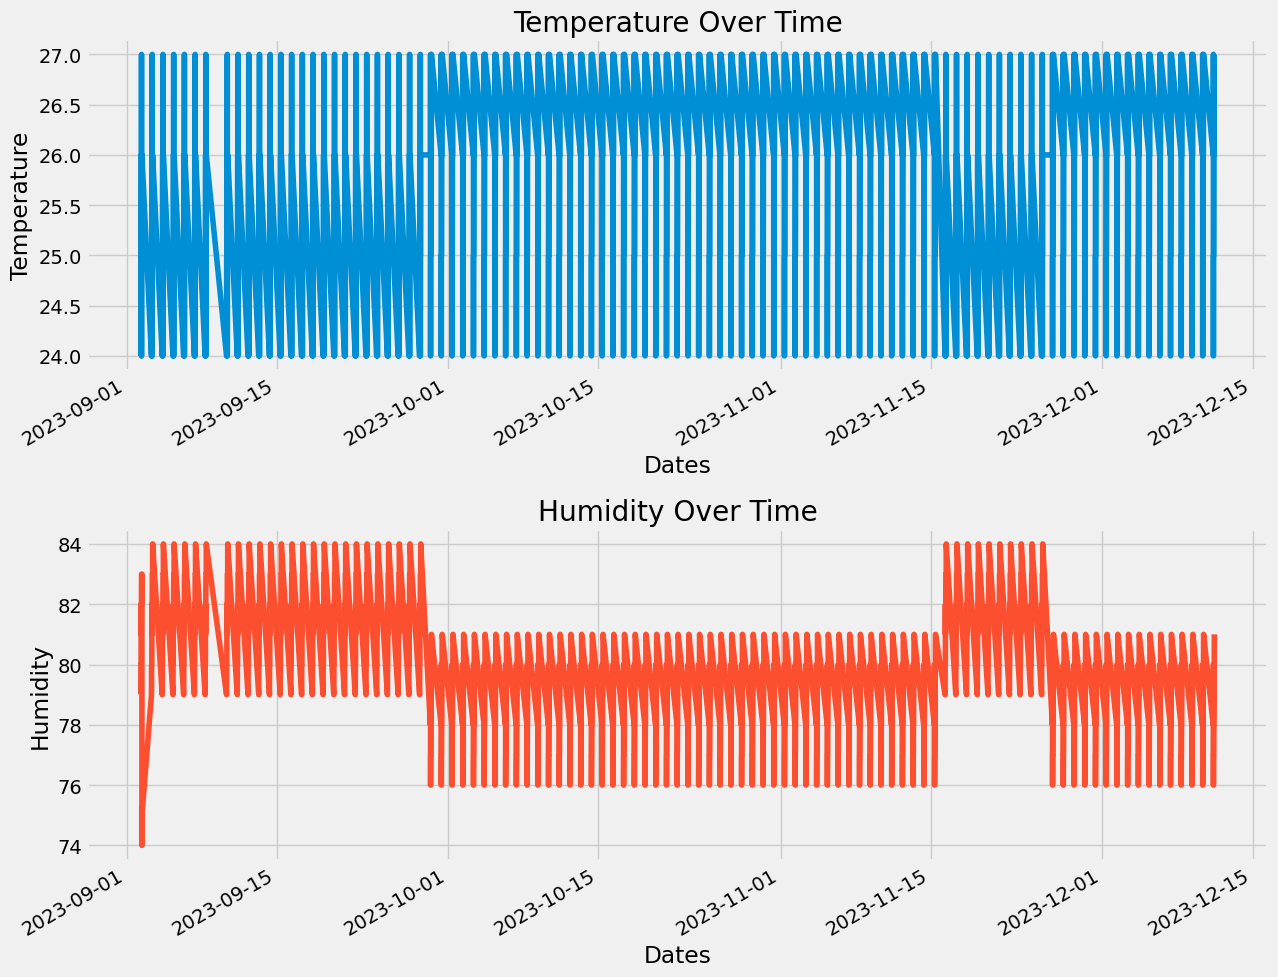

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

# Plot untuk kolom 'temperature'
df['temperature'].plot(ax=axes[0], color=color_pal[0], title='Temperature Over Time')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Temperature')

# Plot untuk kolom 'humidity'
df['humidity'].plot(ax=axes[1], color=color_pal[1], title='Humidity Over Time')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Humidity')

plt.tight_layout()
plt.show()

## 3. Membagi Data Train & Tes dengan Plotnya

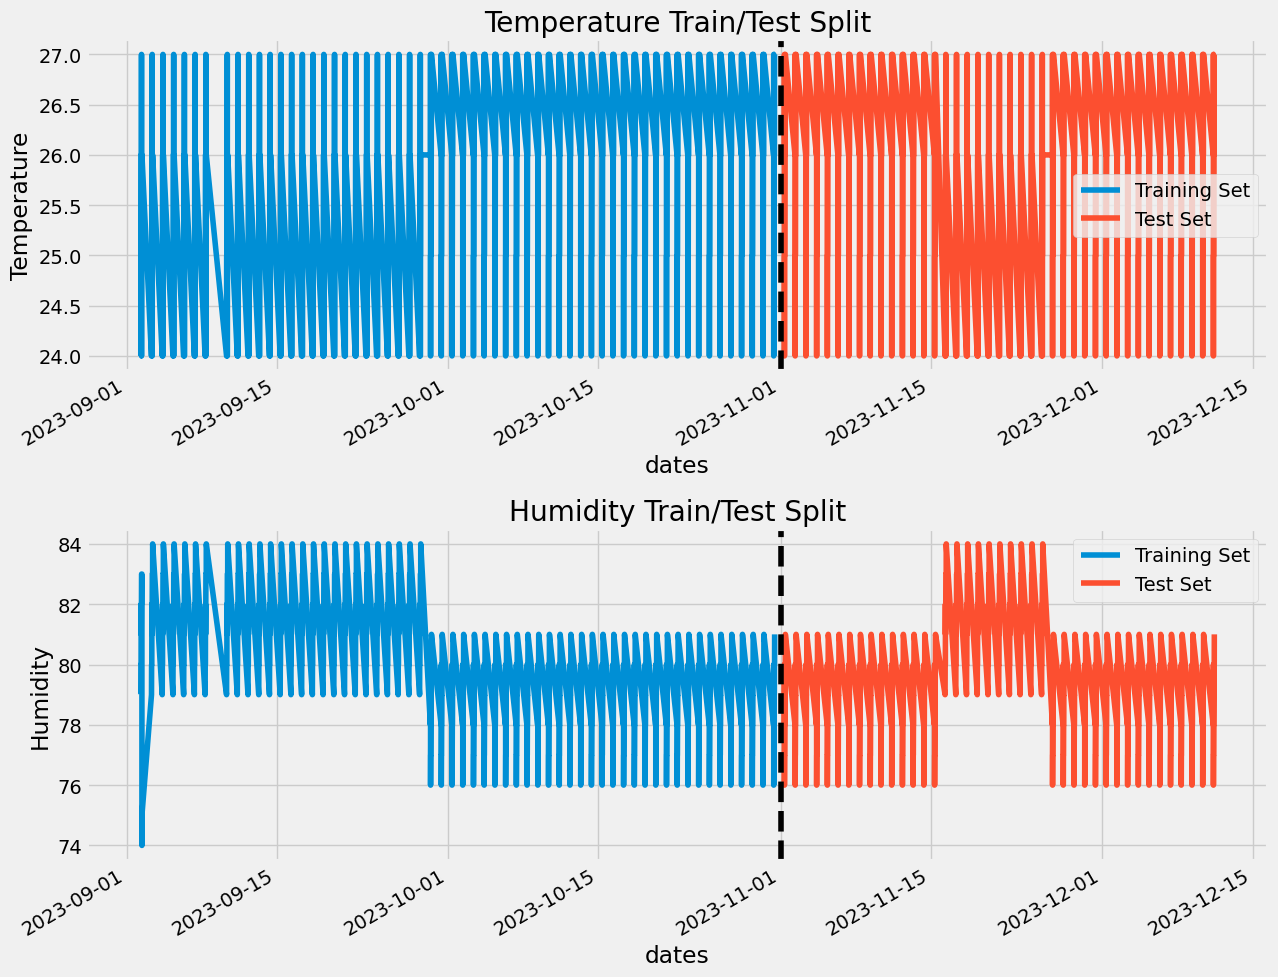

In [ ]:
# Split data train dan test
train = df.loc[df.index < '2023-11-01']
test = df.loc[df.index >= '2023-11-01']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

# Data suhu
train['temperature'].plot(ax=axes[0], label='Training Set', title='Temperature Train/Test Split')
test['temperature'].plot(ax=axes[0], label='Test Set')
axes[0].axvline('2023-11-01', color='black', ls='--')
axes[0].legend(['Training Set', 'Test Set'])
axes[0].set_ylabel('Temperature')

# Data kelembapan
train['humidity'].plot(ax=axes[1], label='Training Set', title='Humidity Train/Test Split')
test['humidity'].plot(ax=axes[1], label='Test Set')
axes[1].axvline('2023-11-01', color='black', ls='--')
axes[1].legend(['Training Set', 'Test Set'])
axes[1].set_ylabel('Humidity')

plt.tight_layout()
plt.show()


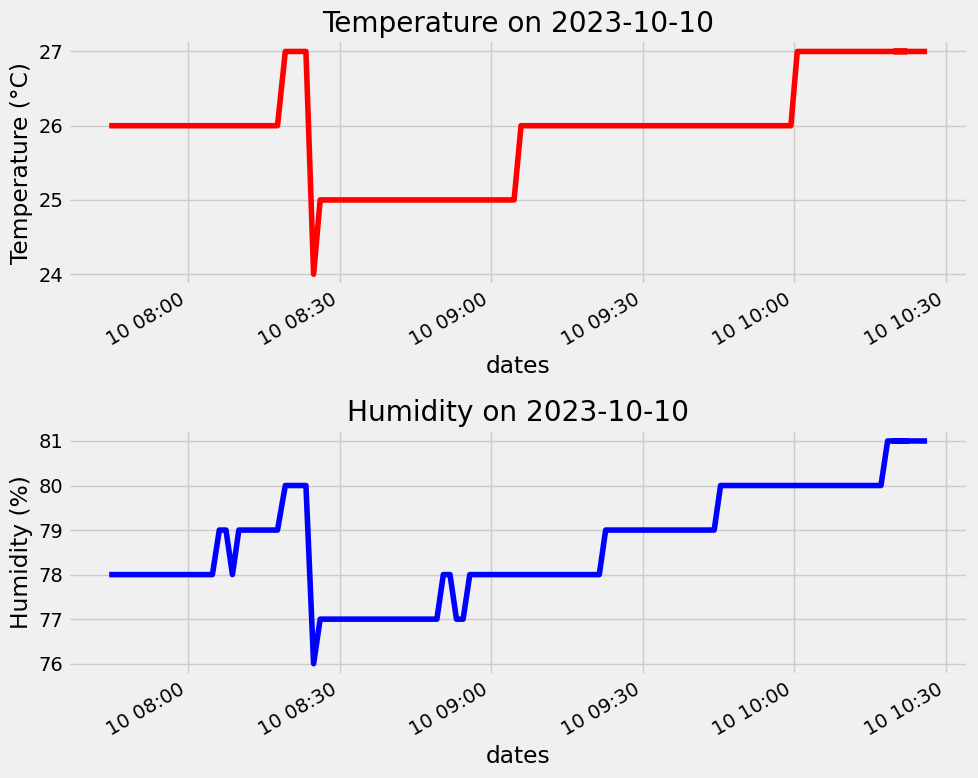

In [ ]:
selected_date = '2023-10-10'
one_day_data = df.loc[selected_date]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot suhu
one_day_data['temperature'].plot(ax=axes[0], color='red', title=f'Temperature on {selected_date}', ylabel='Temperature (°C)')
axes[0].grid(True)

# Plot kelembapan
one_day_data['humidity'].plot(ax=axes[1], color='blue', title=f'Humidity on {selected_date}', ylabel='Humidity (%)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 4. Evaluasi dan Plot Perbandingan Data Aktual dan Prediksi

### Membuat Feature



In [ ]:
def create_features(df):
    # membuat fitur time series berdasarkan index time series
    df = df.copy()
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['week'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

### Visualisasi Feature
Bertujuan untuk membuktikan bahwa fitur yang telah dibuat berhasil, untuk digunakan analisis berikutnya.


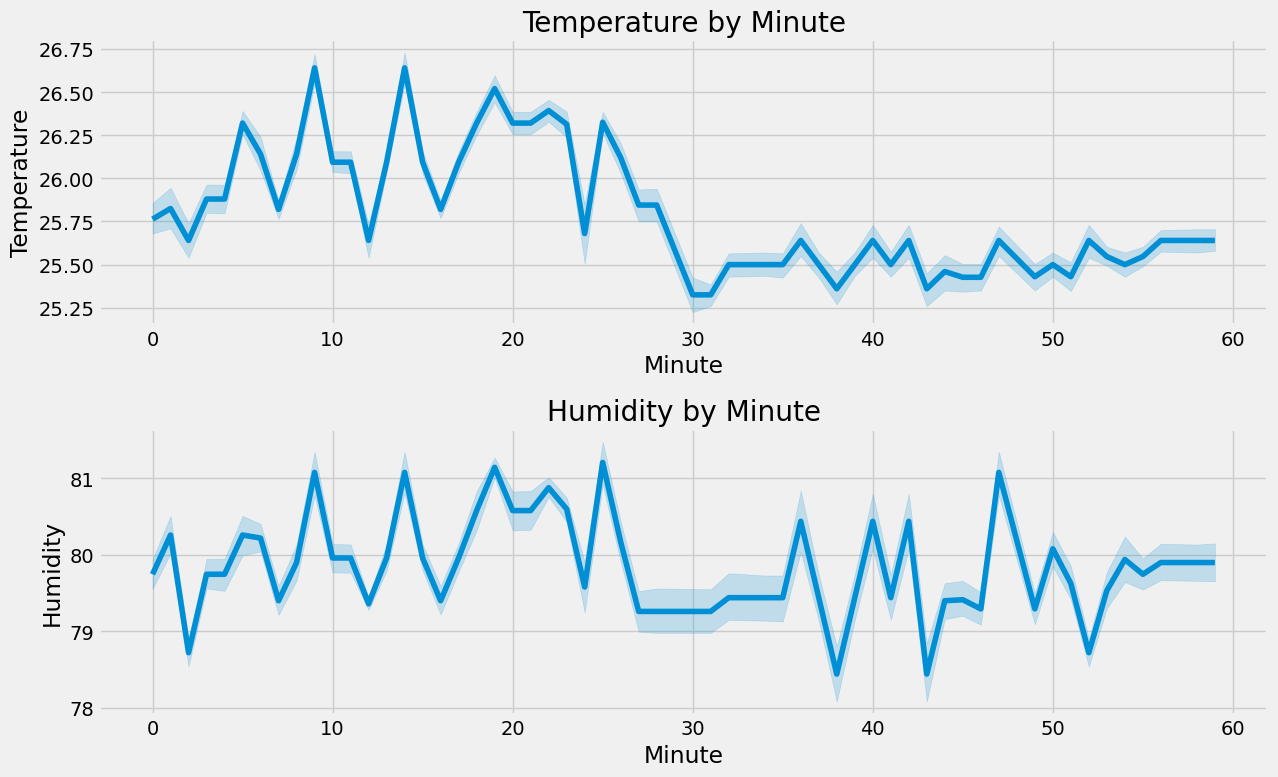

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 8))

# box plot temperatur
sns.lineplot(ax=axes[0], data=df, x='minute', y='temperature')
axes[0].set_title('Temperature by Minute')
axes[0].set_xlabel('Minute')
axes[0].set_ylabel('Temperature')

# box plot kelembapan
sns.lineplot(ax=axes[1], data=df, x='minute', y='humidity')
axes[1].set_title('Humidity by Minute')
axes[1].set_xlabel('Minute')
axes[1].set_ylabel('Humidity')

plt.tight_layout()
plt.show()

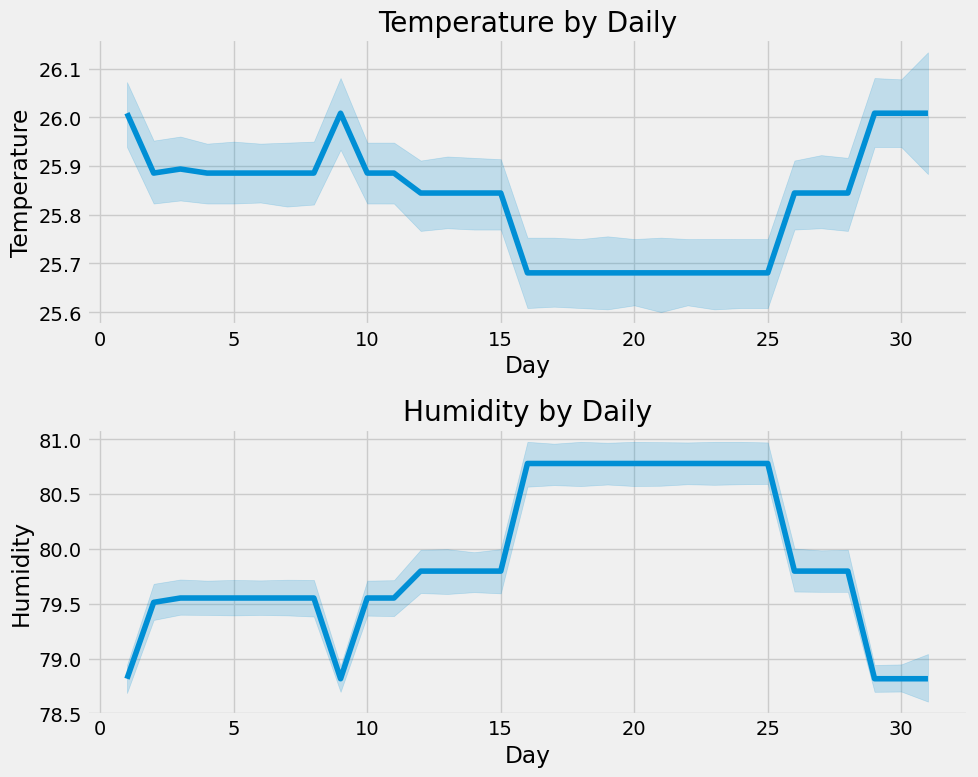

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# box plot temperatur
sns.lineplot(ax=axes[0], data=df, x='day', y='temperature')
axes[0].set_title('Temperature by Daily')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Temperature')

# box plot kelembapan
sns.lineplot(ax=axes[1], data=df, x='day', y='humidity')
axes[1].set_title('Humidity by Daily')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Humidity')

plt.tight_layout()
plt.show()

### Membuat Pemodelan
 Menambahkan atribut waktu seperti minute, hour, day, week, month, dan year ke dalam dataframe sehingga dapat digunakan untuk membangun model prediksi  

In [ ]:
# Menambah fitur waktu pada dataset temperature
train_temp = create_features(train[['temperature']])
test_temp = create_features(test[['temperature']])

# Definisikan fitur dan target untuk temperature
FEATURES_TEMP = ['minute', 'hour', 'day', 'week', 'month', 'year']
TARGET_TEMP = 'temperature'

X_train_temp = train_temp[FEATURES_TEMP]
y_train_temp = train_temp[TARGET_TEMP]

X_test_temp = test_temp[FEATURES_TEMP]
y_test_temp = test_temp[TARGET_TEMP]

# Menambah fitur waktu pada dataset humidity
train_humid = create_features(train[['humidity']])
test_humid = create_features(test[['humidity']])

# Definisikan fitur dan target untuk humidity
FEATURES_HUMID = ['minute', 'hour', 'day', 'week', 'month', 'year']
TARGET_HUMID = 'humidity'

X_train_humid = train_humid[FEATURES_HUMID]
y_train_humid = train_humid[TARGET_HUMID]

X_test_humid = test_humid[FEATURES_HUMID]
y_test_humid = test_humid[TARGET_HUMID]


### Penjelasan tiap parameter yang digunakan:

1. **`base_score=0.5`**  
   Nilai awal prediksi untuk semua pohon regresi. Digunakan sebagai baseline untuk memperbarui prediksi selama proses boosting. Nilai default = 0.5

2. **`booster='gbtree'`**  
   Menentukan tipe booster yang digunakan.  
     - `'gbtree'`: Membangun model dengan pohon keputusan (tree-based model).  
     - Terdapat booster lain seperti `'dart'` atau `'gblinear'`

3. **`n_estimators=1000`**  
   Jumlah maksimum pohon yang akan dibuat selama proses boosting. Semakin besar, semakin lama waktu pelatihan, tetapi model bisa lebih kompleks.

4. **`early_stopping_rounds=50`**  
   Menghentikan pelatihan lebih awal jika performa model tidak membaik dalam 50 iterasi terakhir pada set validasi. Hal ini membantu mencegah overfitting.

5. **`objective='reg:squarederror'`**  
   Fungsi loss untuk regresi. `reg:squarederror` menghitung error sebagai rata-rata kuadrat selisih antara prediksi dan target.

6. **`max_depth=3`**  
   Kedalaman maksimum tiap pohon. Nilai yang lebih rendah mencegah overfitting, sementara nilai yang lebih tinggi memungkinkan pohon menangkap hubungan yang lebih kompleks.

7. **`learning_rate=0.01`**  
   Kecepatan pembaruan model pada setiap iterasi boosting. Nilai kecil seperti 0.01 membuat pelatihan lebih lambat tetapi lebih stabil, membantu menghindari overfitting.

**Proses Pelatihan (`fit`)**  
- **`X_train`**: Data fitur pelatihan.  
- **`y_train`**: Target pelatihan (**temperatur / kelembapan**).  
- **`X_test`** dan **`y_test`**: Digunakan sebagai data validasi untuk memantau performa model selama pelatihan.  
- **`verbose=100`**: Menampilkan hasil pelatihan setiap 100 iterasi untuk memantau proses.

In [ ]:
# Definisikan model untuk temperature
reg_temp = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:squarederror',
                            max_depth=3,
                            learning_rate=0.01)

# Melatih model temperature
reg_temp.fit(X_train_temp, y_train_temp,
             eval_set=[(X_train_temp, y_train_temp), (X_test_temp, y_test_temp)],
             verbose=100)


[0]	validation_0-rmse:25.04932	validation_1-rmse:25.14547
[100]	validation_0-rmse:9.18635	validation_1-rmse:9.21422
[200]	validation_0-rmse:3.38925	validation_1-rmse:3.34395
[300]	validation_0-rmse:1.29453	validation_1-rmse:1.24879
[400]	validation_0-rmse:0.59090	validation_1-rmse:0.61125
[500]	validation_0-rmse:0.40775	validation_1-rmse:0.50338
[600]	validation_0-rmse:0.36551	validation_1-rmse:0.49790
[609]	validation_0-rmse:0.36361	validation_1-rmse:0.49828


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Definisikan model untuk humidity
reg_humid = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                             n_estimators=1000,
                             early_stopping_rounds=50,
                             objective='reg:squarederror',
                             max_depth=3,
                             learning_rate=0.01)

# Melatih model humidity
reg_humid.fit(X_train_humid, y_train_humid,
              eval_set=[(X_train_humid, y_train_humid), (X_test_humid, y_test_humid)],
              verbose=100)


[0]	validation_0-rmse:78.83842	validation_1-rmse:78.27170
[100]	validation_0-rmse:28.88618	validation_1-rmse:29.12573
[200]	validation_0-rmse:10.60079	validation_1-rmse:11.16848
[300]	validation_0-rmse:3.91704	validation_1-rmse:4.69688
[400]	validation_0-rmse:1.50342	validation_1-rmse:2.50115
[500]	validation_0-rmse:0.68863	validation_1-rmse:1.83597
[600]	validation_0-rmse:0.46474	validation_1-rmse:1.64179
[700]	validation_0-rmse:0.41392	validation_1-rmse:1.58036
[800]	validation_0-rmse:0.39124	validation_1-rmse:1.55896
[900]	validation_0-rmse:0.37406	validation_1-rmse:1.55176
[999]	validation_0-rmse:0.36040	validation_1-rmse:1.54959


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance
Menunjukkan seberapa besar pengaruh atau kontribusi setiap fitur terhadap prediksi model. Fitur yang memiliki importance lebih tinggi dianggap memiliki pengaruh lebih besar terhadap hasil prediksi dibandingkan dengan fitur lain.


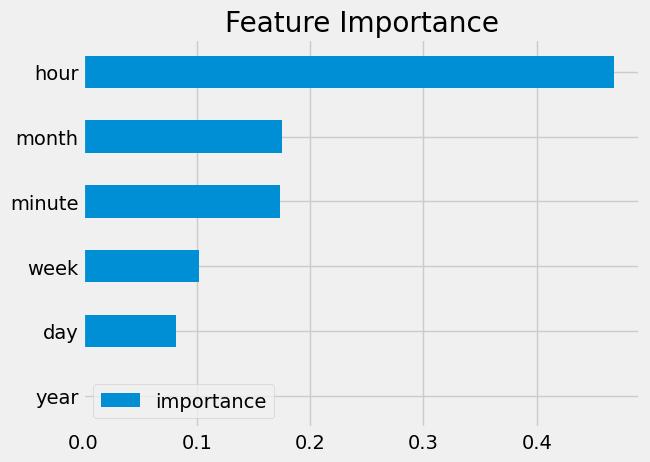

In [ ]:
fi = pd.DataFrame(data=reg_temp.feature_importances_,
             index=reg_temp.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

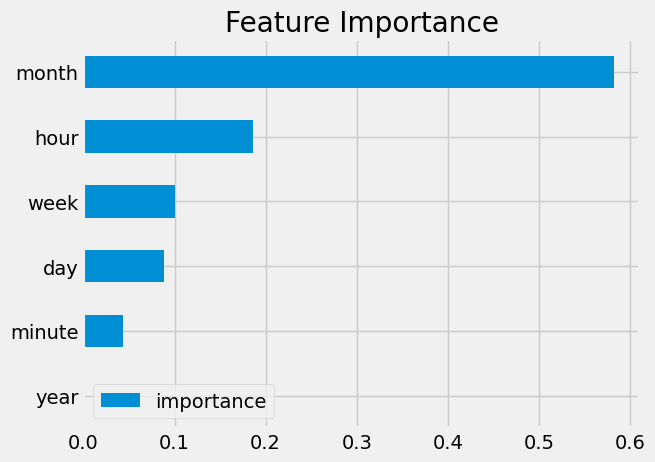

In [ ]:
fi = pd.DataFrame(data=reg_humid.feature_importances_,
             index=reg_humid.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Test Forecasting

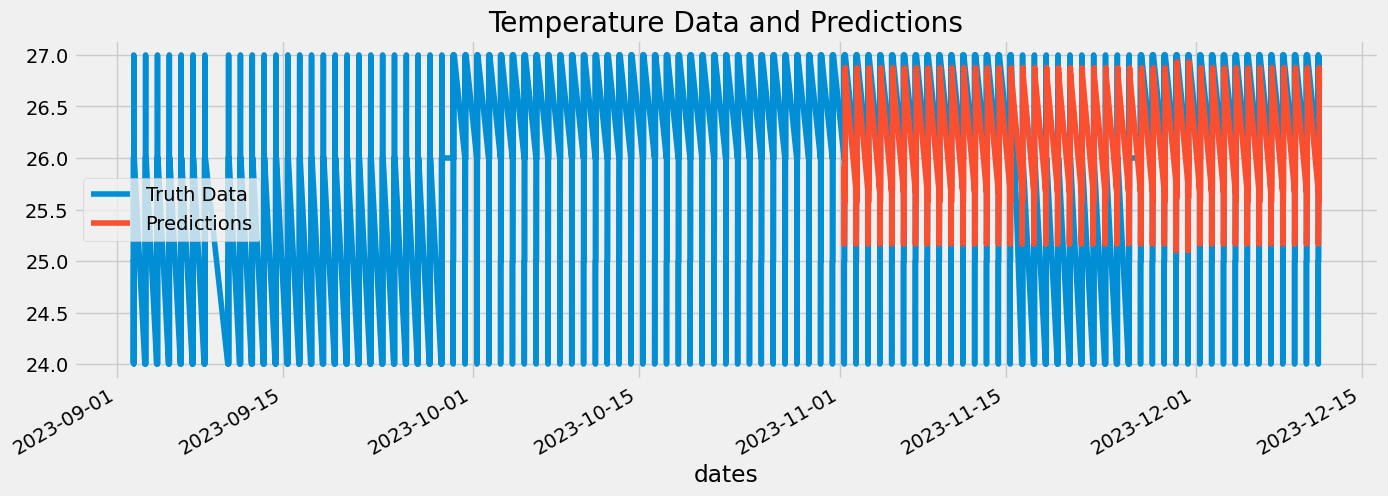

In [ ]:
# Prediksi menggunakan model temperature
test_temp['prediction'] = reg_temp.predict(X_test_temp)

# Gabungkan prediksi ke dalam dataframe test
df_temp = df.merge(test_temp[['prediction']], how='left', left_index=True, right_index=True)

# Plot hasil asli dan prediksi untuk temperature
ax = df_temp[['temperature']].plot(figsize=(15, 5))
df_temp['prediction'].plot(ax=ax)

# Set legend dan judul grafik
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Temperature Data and Predictions')
plt.show()

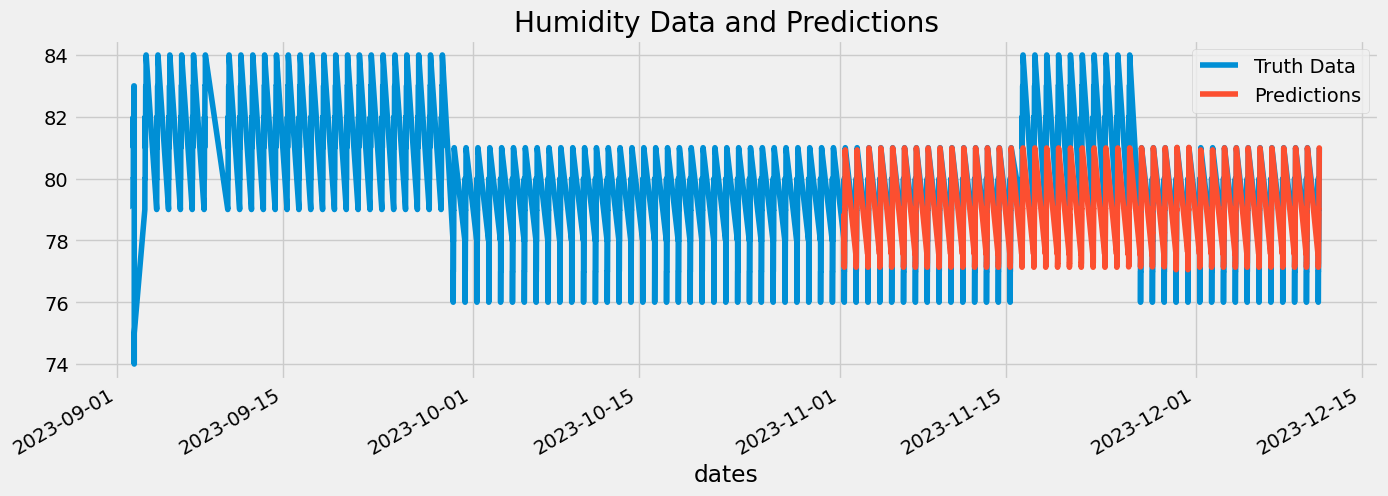

In [ ]:
# Prediksi menggunakan model humidity
test_humid['prediction'] = reg_humid.predict(X_test_humid)

# Gabungkan prediksi ke dalam dataframe test
df_humid = df.merge(test_humid[['prediction']], how='left', left_index=True, right_index=True)

# Plot hasil asli dan prediksi untuk humidity
ax = df_humid[['humidity']].plot(figsize=(15, 5))
df_humid['prediction'].plot(ax=ax)

# Set legend dan judul grafik
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Humidity Data and Predictions')
plt.show()

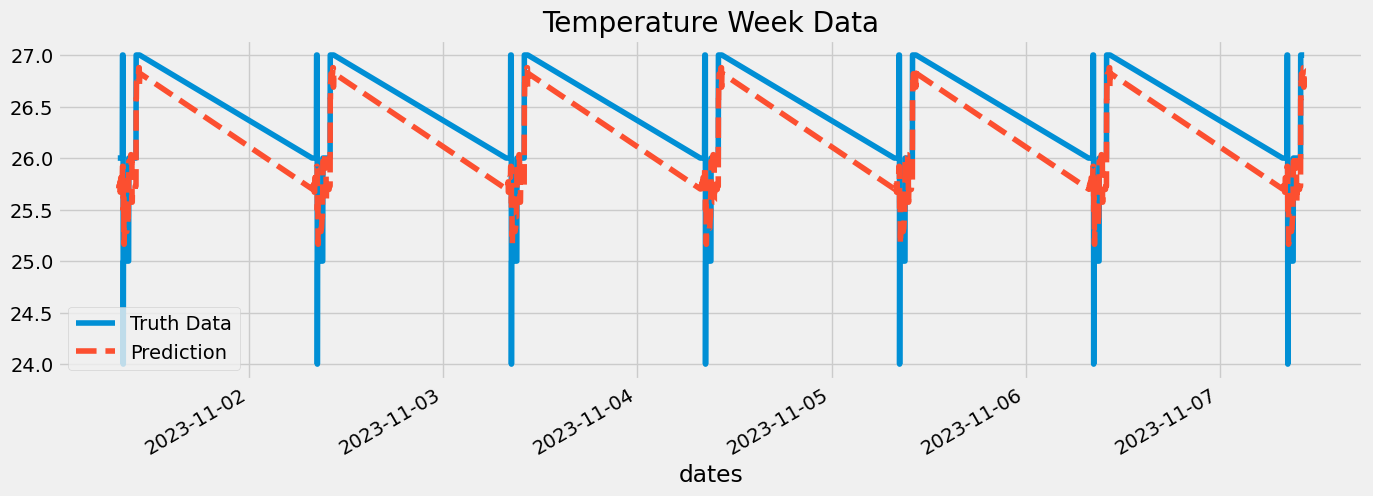

In [ ]:
# Data suhu dalam satu minggu
ax = df_temp.loc[(df_temp.index > '2023-11-01') & (df_temp.index < '2023-11-08')]['temperature'] \
    .plot(figsize=(15, 5), title='Temperature Week Data')
df_temp.loc[(df_temp.index > '2023-11-01') & (df_temp.index < '2023-11-08')]['prediction'] \
    .plot(style='--')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


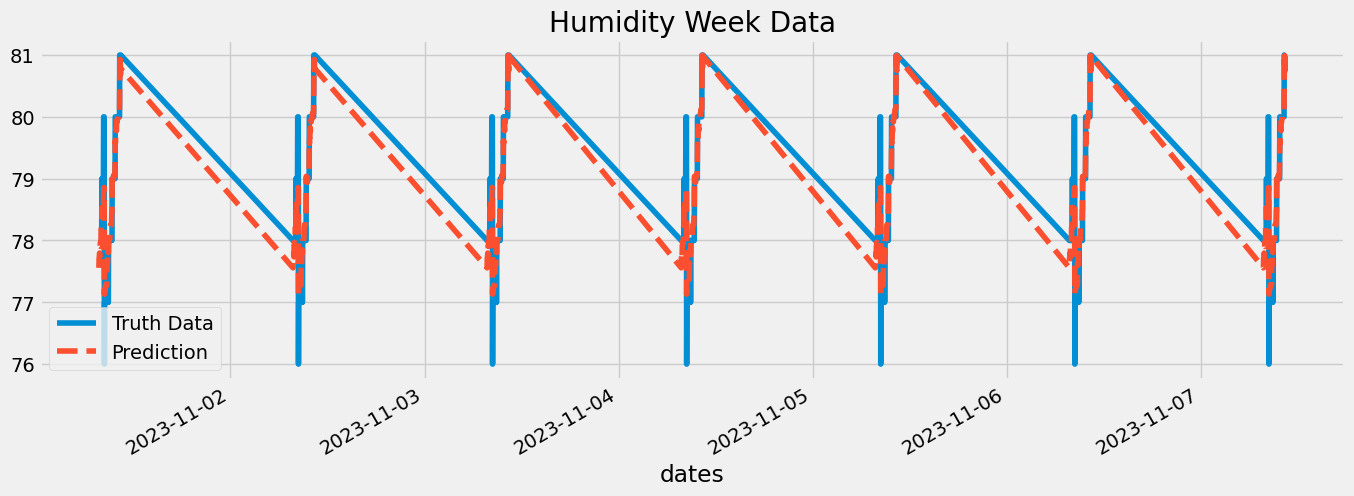

In [ ]:
# Data kelembaban dalam satu minggu
ax = df_humid.loc[(df_humid.index > '2023-11-01') & (df_humid.index < '2023-11-08')]['humidity'] \
    .plot(figsize=(15, 5), title='Humidity Week Data')
df_humid.loc[(df_humid.index > '2023-11-01') & (df_humid.index < '2023-11-08')]['prediction'] \
    .plot(style='--')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


### Nilai RMSE

In [ ]:
score_temp = np.sqrt(mean_squared_error(test_temp['temperature'], test_temp['prediction']))
print(f'RMSE Score on Test set for Temperature: {score_temp:0.2f}')

score_humid = np.sqrt(mean_squared_error(test_humid['humidity'], test_humid['prediction']))
print(f'RMSE Score on Test set for Humidity: {score_humid:0.2f}')


RMSE Score on Test set for Temperature: 0.50
RMSE Score on Test set for Humidity: 1.55


### Menghitung Error
Menampilkan 10 hari dengan error tertinggi dan error terrendah


In [ ]:
test_temp['error'] = np.abs(test_temp['temperature'] - test_temp['prediction'])
test_temp['date'] = test_temp.index.date
error_per_day_temp = test_temp.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)
print("Top 10 Error Days for Temperature:\n", error_per_day_temp)

test_humid['error'] = np.abs(test_humid['humidity'] - test_humid['prediction'])
test_humid['date'] = test_humid.index.date
error_per_day_humid = test_humid.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)
print("Top 10 Error Days for Humidity:\n", error_per_day_humid)


Top 10 Error Days for Temperature:
 date
2023-11-25    0.714053
2023-11-21    0.713279
2023-11-22    0.713279
2023-11-19    0.713279
2023-11-18    0.713279
2023-11-17    0.713279
2023-11-16    0.713279
2023-11-23    0.713279
2023-11-24    0.713279
2023-11-20    0.713279
Name: error, dtype: float64
Top 10 Error Days for Humidity:
 date
2023-11-25    2.944596
2023-11-21    2.935857
2023-11-16    2.935857
2023-11-24    2.935857
2023-11-23    2.935857
2023-11-22    2.935857
2023-11-20    2.935857
2023-11-19    2.935857
2023-11-18    2.935857
2023-11-17    2.935857
Name: error, dtype: float64
